# MLS - RAG


## Recap

### Retrieval-Augmented Generation (RAG)

An important application of LLMs is enabling users to query unstructured data in natural language. This is finding a lot of traction in industries where the data is naturally unstructured in nature (e.g., finance, healthcare). The figure below shows how the finance sector is utilizing LLMs to query and summarize documents.

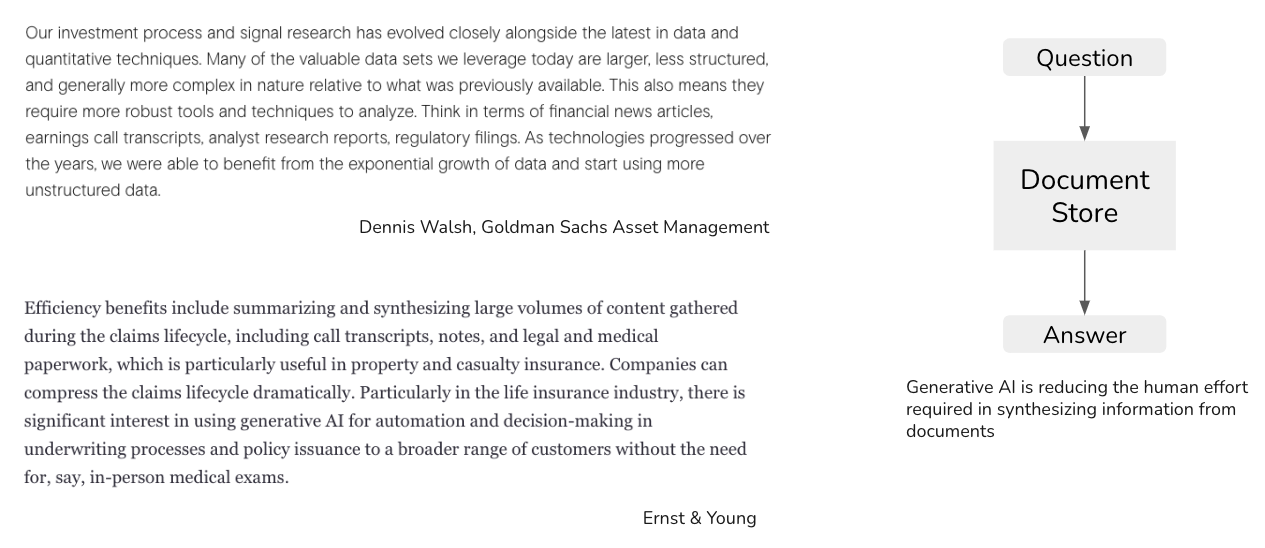

### RAG Building Blocks

#### A workflow for RAG

The figure below depicts the key stages involved in designing a RAG solution using LLMs. Let us look at each stage in detail.

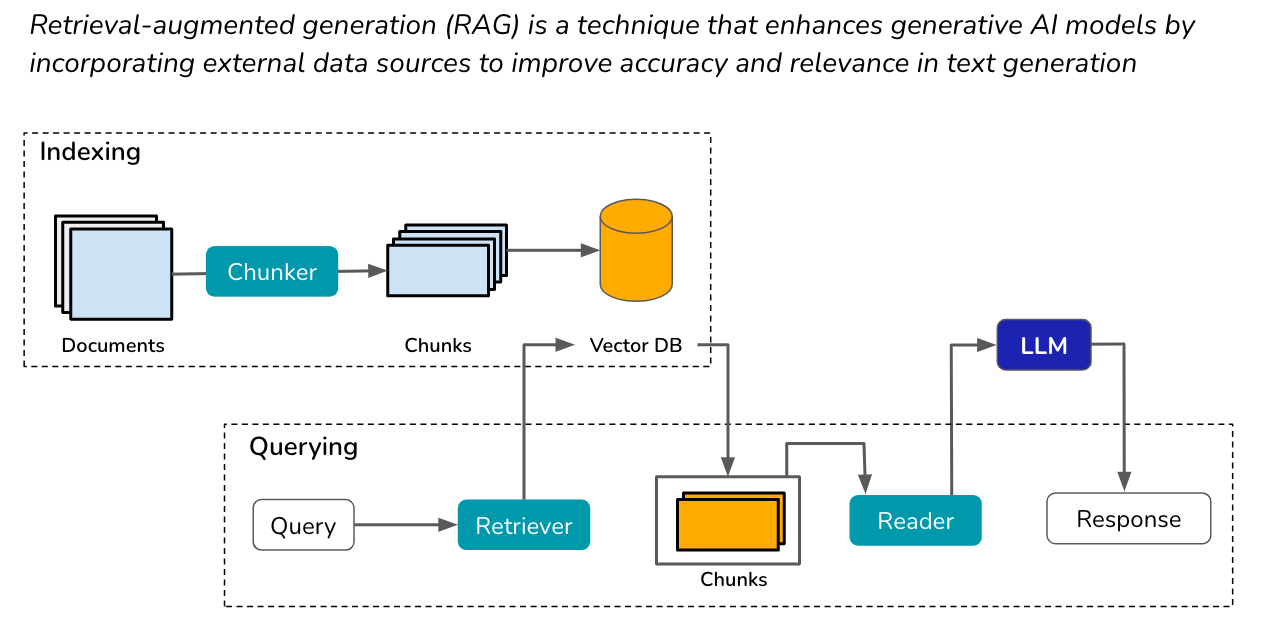

#### Step 1: Creating a Vector Database (Indexing)

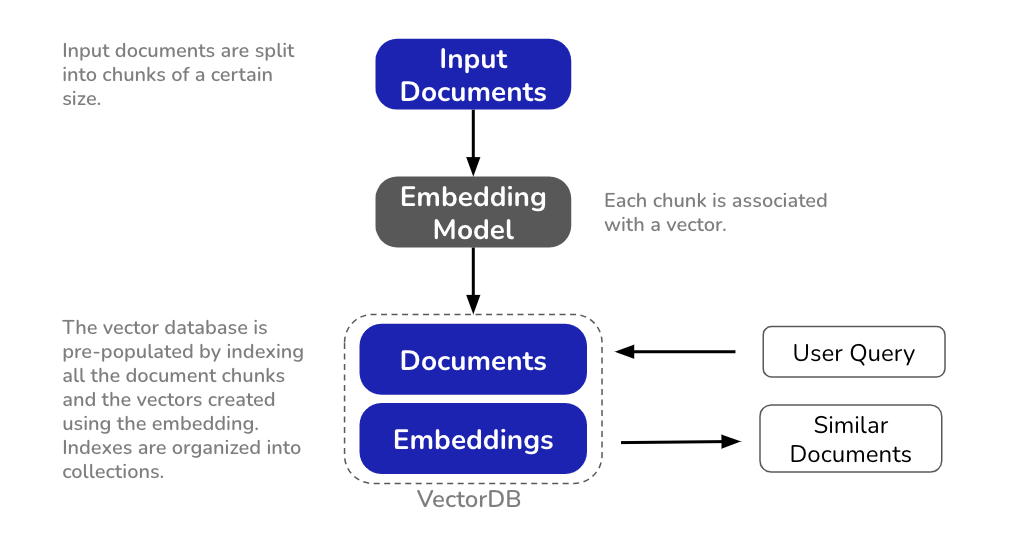

As the above figure indicates, there are two important components of vector database creation that merit a deeper look - choice of embedding model and chunking.

### Choosing an embedding model

As we have established in our LVC, [`gte-large`](https://huggingface.co/thenlper/gte-large) is a good general purpose embedding model.

### Chunking documents

Once the choice of embedding model is made, we can feed the input documents to the model. However, since there are multiple pages across documents (including figures, tables) we will need a method to parse individual portions of the document that is aligned with the embedding model.

We also know that the embedding model cannot process text beyond a fixed context length (512 tokens for `gte-large`). This roughly corresponds to about 400 words or about 1 page of text. With this limitation in mind, we will transform the pdf file into chunks of text that are no more than 512 chunks long. An alternative method would be to chunk the file by sections in the report (e.g., risk factors, legal proceedings, safety disclosures).

A common chunking strategy is to used a fixed-size chunk as defined by the embedding model and use a small overlap between the chunks (see figure below).


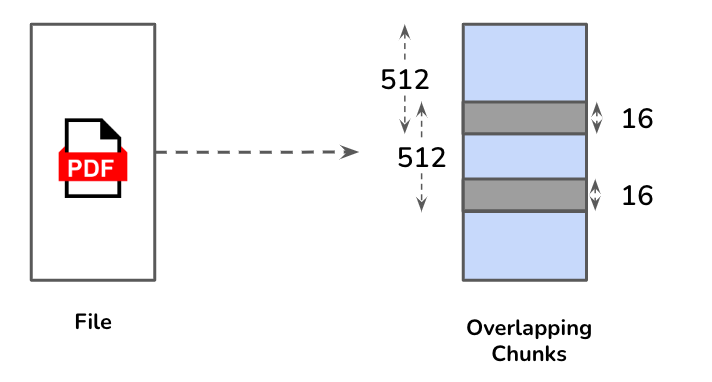

Using an overlap allows for continuity between chunks and retrieval of relevant chunks even when the information relevant to the query is present either at the beginning of the chunk or the end of the chunk.

### Creating a persistent vector database

### Step 2: Querying the Vector Database

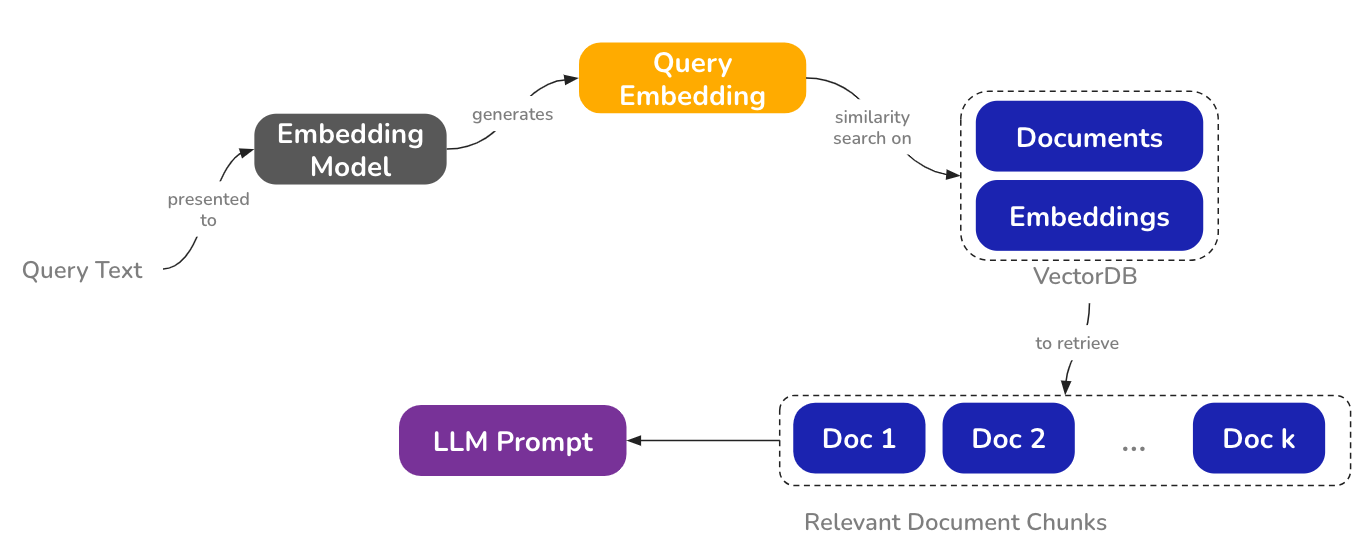

## Business Use Case

**Business Scenario: Enhancing Product Adoption through RAG Chatbot**

In today's rapidly evolving AI community, the introduction of numerous new libraries is accompanied by extensive documentation on their usage. For innovative companies like LangChain and LlamaIndex, it is crucial to ensure widespread adoption of their products by developers. This adoption directly drives their business growth. One effective strategy to increase adoption is to simplify the use of their libraries.

A valuable tool to support this initiative is a chatbot capable of answering questions about the product. While large language models (LLMs) can sometimes generate inaccurate information (a phenomenon known as hallucination), this issue can be mitigated through Retrieval-Augmented Generation (RAG). RAG enhances LLMs by providing them with current, factual information.

**Today's Objective**

Our goal today is to develop a chatbot for Streamlit Documentation that assists users by answering questions about using streamlit replicating the chatbot feature on LangChain. To ensure the development can be completed within our session, we will implement this on a sample of Streamlit documentation consisting of 298 documents.

This project involves:
1. Integrating RAG to enhance the accuracy of the chatbot.
2. Testing the chatbot's performance on a selected subset of queries.

By successfully implementing this chatbot, we aim to provide a tool that simplifies the user experience, thereby driving higher adoption rates for Streamlit.

We will perform this in two steps like we have done in our previous MLS. However, this time we are going to do it in a single notebook.

First we will create the vector database with document embeddings and store it on Gdrive.

In the second stage, we will load the database from Gdrive, perfrom querying and then rate our RAG using a larger model.


For the first part, use a T4 GPU and for the second part you can switch to a CPU.

**Connect to a T4 GPU Instance.**

### Setup

In [ ]:
!pip install -q openai==1.23.2 \
                tiktoken==0.6.0 \
                langchain==0.1.1 \
                langchain-community==0.0.13 \
                chromadb==0.4.22 \
                sentence-transformers==2.3.1 \
                datasets

In [ ]:
import json
import tiktoken
from datasets import load_dataset

import pandas as pd

from openai import OpenAI

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.documents import Document

from langchain_community.embeddings.sentence_transformer import (
    SentenceTransformerEmbeddings
)
from langchain_community.vectorstores import Chroma

from google.colab import userdata, drive

## Impementing RAG

## Assemble Vector Database (One-time Setup)

### Download and Prepare Data

Let's start by loading the dataset.

In [ ]:
docs = load_dataset("sai-lohith/streamlit_docs")

In [ ]:
docs = docs['train'].to_pandas()

In [ ]:
docs.shape

In [ ]:
docs.head()

Let's check one of the documents to understand what we are working with.

In [ ]:
print(docs.iloc[3,1])

It is long document. Let's do an analysis of the lengths of the docs.

Before that, we can observe that the first line of the document is useless. Let's check if this line is present in all documents. If so, let's remove it.

In [ ]:
docs['Text'] = docs['Text'].apply(lambda text: '\n'.join(text.split('\n')[1:]))

Let's check the number of tokens in each document.

We are going to use tiktoken as a proxy to count the number of tokens in each document. It uses OPENAI based encoding to ind out the number of token which is not the same as our encoding however, this works as a good proxy.

In [ ]:
def token_count(text):

    """
    Return the number of tokens used by texts.
    Adapted from the Open AI cookbook token counter
    """

    encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")

    return len(encoding.encode(text))

In [ ]:
docs['token_count'] = docs['Text'].apply(token_count)

Let's plot the number of token in each document to understand our dataset better.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Create the violin plot on the first subplot
sns.violinplot(data=docs['token_count'], ax=axs[0])

# Create the histogram on the second subplot
docs['token_count'].hist(ax=axs[1], bins = 50)

# Display the plots
plt.tight_layout()
plt.show()

# Show the plot
plt.show()

We can see that most of our data has less than 1600 token count. With a chunk size of 1024, we will get roughly 1-3 chunks for a majority of the docs. However, we need to have a decent overlap so that context is maintained across chunks. Let's have an overlap of 50 tokens.



### Chunking

In [ ]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    encoding_name='cl100k_base',
    chunk_size=512,
    chunk_overlap=50
)

Let's create a splitter that will split and chunk using our chunking strategy. Each doc will be chunked into smaller parts however, all the individual chunks have the link from the same parent document.

In [ ]:
new_data = []

for index, row in docs.iterrows():
    chunks = text_splitter.split_text(row['Text'])
    for chunk in chunks:
        new_data.append({'chunk': chunk, 'link': row['Link']})

chunks = pd.DataFrame(new_data)

In [ ]:
chunks.shape

Our 298 docs have become 2277 docs now. Let's randomly look at few chunks.

In [ ]:
chunks.head()

In [ ]:
chunks.iloc[23,0]

### Database Creation

In [ ]:
embedding_model = SentenceTransformerEmbeddings(model_name='gte-large-en-v1.5')

In [ ]:
docs = [Document(page_content = doc, metadata = {"Link":link})for doc, link in zip(chunks['chunk'],chunks['link'])
                 ]

In [ ]:
len(docs)

In [ ]:
print(docs[0])

In [ ]:
documentation = Chroma.from_documents(
    docs,
    embedding_model,
    collection_name="streamlit",
    persist_directory='./streamlitdb'
)

In [ ]:
documentation.persist()

Let's check the contents of the vectorDB

In [ ]:
documentation.get()

Let's create a retriever that fetches 5 responses for every query.

In [ ]:
retriever = documentation.as_retriever(
    search_type='similarity',
    search_kwargs={'k': 5}
)

Upload the current DB state to Google Drive, so we can avoid using GPU during querying.

In [ ]:
drive.mount('/content/drive')

In [ ]:
!cp -r streamlitdb /content/drive/MyDrive/

Since the vector database state is saved, we no longer need the GPU. **Please switch to a CPU instance.**

# Part - 2

Let's setup the CPU instance

### Setup

In [ ]:
!pip install -q openai==1.23.2 \
                tiktoken==0.6.0 \
                langchain==0.1.1 \
                langchain-community==0.0.13 \
                chromadb==0.4.22 \
                sentence-transformers==2.3.1

In [ ]:
import json
import tiktoken

import pandas as pd

from openai import OpenAI

from langchain_community.embeddings.sentence_transformer import (
    SentenceTransformerEmbeddings
)
from langchain_community.vectorstores import Chroma

from google.colab import userdata, drive

In [ ]:
anyscale_api_key = userdata.get('anyscale_api_key')

In [ ]:
client = OpenAI(
    base_url="https://api.endpoints.anyscale.com/v1",
    api_key=anyscale_api_key
)

We are going to use Mixtral 8x7B model for this exercise due to it's higher performance.

In [ ]:
model_name = 'mistralai/Mixtral-8x7B-Instruct-v0.1'

## Impementing RAG

## Load Vector DB from Google Drive

In [ ]:
embedding_model = SentenceTransformerEmbeddings(model_name='gte-large-en-v1.5')

In [ ]:
drive.mount('/content/drive')

Since we persisted the database to a Google Drive location, we can download the database to the instance using its unique id like so:

In [ ]:
persisted_vectordb_location = '/content/drive/MyDrive/streamlitdb'

In practise, the database is maintained as a separate entity and CRUD operations are managed just as one would for normal databases (e.g., relational databases).

In [ ]:
streamlitdb = Chroma(
    collection_name="streamlit",
    persist_directory=persisted_vectordb_location,
    embedding_function=embedding_model
)

In [ ]:
streamlitdb.get() #Let's check if we have all the embeddings ready.

Let's test our vectorDB with a test query.

In [ ]:
query = "How to draw charts in streamlit"

In [ ]:
docs = streamlitdb.similarity_search(query, k=5)

In [ ]:
for i, doc in enumerate(docs):
    print(f"Retrieved chunk {i+1}: \n")
    print(doc.page_content.replace('\t', ' '))
    print("Source: ", doc.metadata['Link'],"\n ===================================================== \n")
    print('\n')

In [ ]:
retriever = streamlitdb.as_retriever(
    search_type='similarity',
    search_kwargs={'k': 5}
)

The vectorDB seems to work fine, let's move on to the next step.

## RAG Q&A

### Prompt Design

Let's formulate a prompt to fetch a Retrieval Augmented Generation from the LLM.

It is essential to ensure that the LLM does not generate hallucinated or random answers when faced with irrelevant information in the retrieved documents. Additionally, the LLM should provide the source of the information it offers. Including source citations will enhance the reliability and credibility of our chatbot.

In [ ]:
qna_system_message = """
You are an assistant to a coder. Your task is to provide relevant information about the Python package Streamlit.

User input will include the necessary context for you to answer their questions. This context will begin with the token: ###Context.
The context contains references to specific portions of documents relevant to the user's query, along with source links.
The source for a context will begin with the token ###Source

When crafting your response:
1. Select only context relevant to answer the question.
2. Include the source links in your response.
3. User questions will begin with the token: ###Question.
4. If the question is irrelevant to streamlit respond with - "I am an assistant for streamlit Docs. I can only help you with questions related to streamlit"

Please adhere to the following guidelines:
- Your response should only be about the question asked and nothing else.
- Answer only using the context provided.
- Do not mention anything about the context in your final answer.
- If the answer is not found in the context, it is very very important for you to respond with "I don't know. Please check the docs @ 'https://docs.streamlit.io/'"
- Always quote the source when you use the context. Cite the relevant source at the end of your response under the section - Source:
- Do not make up sources. Use the links provided in the sources section of the context and nothing else. You are prohibited from providing other links/sources.

Here is an example of how to structure your response:

Answer:
[Answer]

Source:
[Source]
"""

In [ ]:
qna_user_message_template = """
###Context
Here are some documents and their source links that are relevant to the question mentioned below.
{context}

###Question
{question}
"""

### Retrieving relevant documents

Let's test our RAG chatbot now.

In [ ]:
user_input = "How to deploy my streamlit app using Docker on GCP?"

In [ ]:
relevant_document_chunks = retriever.get_relevant_documents(user_input)

In [ ]:
len(relevant_document_chunks)

### Composing the response

In [ ]:
relevant_document_chunks = retriever.get_relevant_documents(user_input)
context_list = [d.page_content + "\n ###Source: " + d.metadata['Link'] + "\n\n " for d in relevant_document_chunks]

context_for_query = ". ".join(context_list)

prompt = [
    {'role':'system', 'content': qna_system_message},
    {'role': 'user', 'content': qna_user_message_template.format(
         context=context_for_query,
         question=user_input
        )
    }
]

try:
    response = client.chat.completions.create(
        model=model_name,
        messages=prompt,
        temperature=0
    )

    prediction = response.choices[0].message.content.strip()
except Exception as e:
    prediction = f'Sorry, I encountered the following error: \n {e}'

print(prediction)

Let's check the context once.

In [ ]:
print(context_for_query)

We can see that the context provided to the chatbot has all the information provided in the response however it was not structured well. The response from the LLM is structured and provides sources of the information included in the response.

As a next step, we can also add the documents from community portal like stackoverflow where there are plenty of errors and their solutions posted. This will improve the chatbot further by giving it information on how to resolve errors. Post this users can copy paste their errors and expect to find solution for them. However, this is out of scope for our session. We encourage you to build on top of this notebook.

Let us now use the LLM-as-a-judge method to check the quality of the RAG system on two parameters - retrieval and generation. We illustrate this evaluation based on the answeres generated to the question from the previous section.

## Evaluation

In [ ]:
rater_model = "meta-llama/Meta-Llama-3-70B-Instruct"

In [ ]:
groundedness_rater_system_message = """
You are tasked with rating AI generated answers to questions posed by users.
You will be presented a question, context used by the AI system to generate the answer and an AI generated answer to the question.
In the input, the question will begin with ###Question, the context will begin with ###Context and includes ###Source while the AI generated answer will begin with ###Answer.

Evaluation criteria:
The task is to judge the extent to which the metric is followed by the answer.
1 - The metric is not followed at all
2 - The metric is followed only to a limited extent
3 - The metric is followed to a good extent
4 - The metric is followed mostly
5 - The metric is followed completely

Metric:
The answer should be derived only from the information presented in the context

Instructions:
1. First write down the steps that are needed to evaluate the answer as per the metric.
2. Give a step-by-step explanation if the answer adheres to the metric considering the question and context as the input.
3. Next, evaluate the extent to which the metric is followed.
4. Use the previous information to rate the answer using the evaluaton criteria and assign a score.
"""

In [ ]:
relevance_rater_system_message = """
You are tasked with rating AI generated answers to questions posed by users.
You will be presented a question, context used by the AI system to generate the answer and an AI generated answer to the question.
In the input, the question will begin with ###Question, the context will begin with ###Context while the AI generated answer will begin with ###Answer.

Evaluation criteria:
The task is to judge the extent to which the metric is followed by the answer.
1 - The metric is not followed at all
2 - The metric is followed only to a limited extent
3 - The metric is followed to a good extent
4 - The metric is followed mostly
5 - The metric is followed completely

Metric:
Relevance measures how well the answer addresses the main aspects of the question, based on the context.
Consider whether all and only the important aspects are contained in the answer when evaluating relevance.

Instructions:
1. First write down the steps that are needed to evaluate the context as per the metric.
2. Give a step-by-step explanation if the context adheres to the metric considering the question as the input.
3. Next, evaluate the extent to which the metric is followed.
4. Use the previous information to rate the context using the evaluaton criteria and assign a score out of 5.
"""

In [ ]:
user_message_template = """
###Question
{question}

###Context
{context}

###Answer
{answer}
"""

In [ ]:
user_input = "What are the different charts that i can produce in streamlit?"

In [ ]:
relevant_document_chunks = retriever.get_relevant_documents(user_input)
context_list = [d.page_content + "\n ###Source: " + d.metadata['Link'] + "\n\n " for d in relevant_document_chunks]

context_for_query = ". ".join(context_list)

prompt = [
    {'role':'system', 'content': qna_system_message},
    {'role': 'user', 'content': qna_user_message_template.format(
         context=context_for_query,
         question=user_input
        )
    }
]

response = client.chat.completions.create(
    model=model_name,
    messages=prompt,
    temperature=0
)

answer = response.choices[0].message.content.strip()

In [ ]:
print(answer)

In [ ]:
groundedness_prompt = [
    {'role':'system', 'content': groundedness_rater_system_message},
    {'role': 'user', 'content': user_message_template.format(
        question=user_input,
        context=context_for_query,
        answer=answer
        )
    }
]

In [ ]:
response = client.chat.completions.create(
    model=rater_model,
    messages=groundedness_prompt,
    temperature=0
)

print(response.choices[0].message.content)

In [ ]:
relevance_prompt = [
    {'role':'system', 'content': relevance_rater_system_message},
    {'role': 'user', 'content': user_message_template.format(
        question=user_input,
        context=context_for_query,
        answer=answer
        )
    }
]

In [ ]:
response = client.chat.completions.create(
    model=rater_model,
    messages=relevance_prompt,
    temperature=0
)

print(response.choices[0].message.content)

Our RAG implementation seems to work fine. Now, let's test it over a larger selection of documents.

In [ ]:
# List of queries
queries = [
    #remember some of the following questions might not have answers in the sampled documentation of streamlit!
    "How to install Streamlit?",
    "How to create a slider widget in Streamlit?",
    "How to display a dataframe in Streamlit?",
    "How to create a button in Streamlit?",
    "How to deploy a Streamlit app on Heroku?",
    "How to use Streamlit st.cache?",
    "How to upload a file in Streamlit?",
    "How to create a sidebar in Streamlit?",
    "How to plot a graph in Streamlit?",
    "How to handle session state in Streamlit?"
    #Let's also add some queries which are not relevant. Let's see if the model outputs "I Don't Know"
    "who is barack obama",
    "how to destroy my laptop",
    "how to use streamlit to conjure devils"
]
# DataFrame to store the results
df = pd.DataFrame(columns=['query', 'response', 'context', 'groundedness_evaluation', 'relevance_evaluation'])

for query in queries:


    relevant_document_chunks = retriever.get_relevant_documents(query)
    context_list = [d.page_content + "\n ###Source: " + d.metadata['Link'] + "\n\n " for d in relevant_document_chunks]

    context_for_query = ". ".join(context_list)

    prompt = [
        {'role':'system', 'content': qna_system_message},
        {'role': 'user', 'content': qna_user_message_template.format(
            context=context_for_query,
            question=query
            )
        }
    ]


    response = client.chat.completions.create(
        model=model_name,
        messages=prompt,
        temperature=0
    )

    answer = response.choices[0].message.content.strip()
    # print(context_for_query)
    # print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    # print(answer)
    # print("====================================================================")

    # Groundedness prompt
    groundedness_prompt = [
        {'role':'system', 'content': groundedness_rater_system_message},
        {'role': 'user', 'content': user_message_template.format(
            question=query,
            context=context_for_query,
            answer=answer
            )
        }
    ]

    # Get the groundedness response
    response = client.chat.completions.create(
        model=rater_model,
        messages=groundedness_prompt,
        temperature=0
    )
    groundedness_response = response.choices[0].message.content

    # Relevance prompt
    relevance_prompt = [
        {'role':'system', 'content': relevance_rater_system_message},
        {'role': 'user', 'content': user_message_template.format(
            question=query,
            context=context_for_query,
            answer=answer
            )
        }
    ]

    # Get the relevance response
    response = client.chat.completions.create(
        model=rater_model,
        messages=relevance_prompt,
        temperature=0
    )
    relevance_response = response.choices[0].message.content

    # Store the query and responses in the DataFrame
    df = pd.concat([df, pd.DataFrame([{'query': query,'response': answer, 'context': context_for_query, 'groundedness_evaluation': groundedness_response, 'relevance_evaluation': relevance_response}])], ignore_index=True)
df.head(13)

In [ ]:
df.iloc[0,1]